# Homework and bake-off: word-level entailment with neural networks

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Spring 2020"

## Contents

1. [Overview](#Overview)
1. [Set-up](#Set-up)
1. [Data](#Data)
  1. [Edge disjoint](#Edge-disjoint)
  1. [Word disjoint](#Word-disjoint)
1. [Baseline](#Baseline)
  1. [Representing words: vector_func](#Representing-words:-vector_func)
  1. [Combining words into inputs: vector_combo_func](#Combining-words-into-inputs:-vector_combo_func)
  1. [Classifier model](#Classifier-model)
  1. [Baseline results](#Baseline-results)
1. [Homework questions](#Homework-questions)
  1. [Hypothesis-only baseline [2 points]](#Hypothesis-only-baseline-[2-points])
  1. [Alternatives to concatenation [2 points]](#Alternatives-to-concatenation-[2-points])
  1. [A deeper network [2 points]](#A-deeper-network-[2-points])
  1. [Your original system [3 points]](#Your-original-system-[3-points])
1. [Bake-off [1 point]](#Bake-off-[1-point])

## Overview

The general problem is word-level natural language inference.

Training examples are pairs of words $(w_{L}, w_{R}), y$ with $y = 1$ if $w_{L}$ entails $w_{R}$, otherwise $0$.

The homework questions below ask you to define baseline models for this and develop your own system for entry in the bake-off, which will take place on a held-out test-set distributed at the start of the bake-off. (Thus, all the data you have available for development is available for training your final system before the bake-off begins.)

<img src="fig/wordentail-diagram.png" width=600 alt="wordentail-diagram.png" />

## Set-up

See [the first notebook in this unit](nli_01_task_and_data.ipynb) for set-up instructions.

In [122]:
from collections import defaultdict
import json
import numpy as np
import os
import pandas as pd
from torch_shallow_neural_classifier import TorchShallowNeuralClassifier
import nli
import utils
import io

In [2]:
DATA_HOME = 'data'

NLIDATA_HOME = os.path.join(DATA_HOME, 'nlidata')

wordentail_filename = os.path.join(
    NLIDATA_HOME, 'nli_wordentail_bakeoff_data.json')

GLOVE_HOME = os.path.join(DATA_HOME, 'glove.6B')

## Data

I've processed the data into two different train/test splits, in an effort to put some pressure on our models to actually learn these semantic relations, as opposed to exploiting regularities in the sample.

* `edge_disjoint`: The `train` and `dev` __edge__ sets are disjoint, but many __words__ appear in both `train` and `dev`.
* `word_disjoint`: The `train` and `dev` __vocabularies are disjoint__, and thus the edges are disjoint as well.

These are very different problems. For `word_disjoint`, there is real pressure on the model to learn abstract relationships, as opposed to memorizing properties of individual words.

In [3]:
with open(wordentail_filename) as f:
    wordentail_data = json.load(f)

The outer keys are the  splits plus a list giving the vocabulary for the entire dataset:

In [4]:
wordentail_data.keys()

dict_keys(['edge_disjoint', 'vocab', 'word_disjoint'])

### Edge disjoint

In [5]:
wordentail_data['edge_disjoint'].keys()

dict_keys(['dev', 'train'])

This is what the split looks like; all three have this same format:

In [6]:
wordentail_data['edge_disjoint']['dev'][: 5]

[[['sweater', 'stroke'], 0],
 [['constipation', 'hypovolemia'], 0],
 [['disease', 'inflammation'], 0],
 [['herring', 'animal'], 1],
 [['cauliflower', 'outlook'], 0]]

Let's test to make sure no edges are shared between `train` and `dev`:

In [7]:
nli.get_edge_overlap_size(wordentail_data, 'edge_disjoint')

0

As we expect, a *lot* of vocabulary items are shared between `train` and `dev`:

In [8]:
nli.get_vocab_overlap_size(wordentail_data, 'edge_disjoint')

2916

This is a large percentage of the entire vocab:

In [9]:
len(wordentail_data['vocab'])

8470

Here's the distribution of labels in the `train` set. It's highly imbalanced, which will pose a challenge for learning. (I'll go ahead and reveal that the `dev` set is similarly distributed.)

In [10]:
def label_distribution(split):
    return pd.DataFrame(wordentail_data[split]['train'])[1].value_counts()

In [11]:
label_distribution('edge_disjoint')

0    14650
1     2745
Name: 1, dtype: int64

### Word disjoint

In [12]:
wordentail_data['word_disjoint'].keys()

dict_keys(['dev', 'train'])

In the `word_disjoint` split, no __words__ are shared between `train` and `dev`:

In [13]:
nli.get_vocab_overlap_size(wordentail_data, 'word_disjoint')

0

Because no words are shared between `train` and `dev`, no edges are either:

In [14]:
nli.get_edge_overlap_size(wordentail_data, 'word_disjoint')

0

The label distribution is similar to that of `edge_disjoint`, though the overall number of examples is a bit smaller:

In [15]:
label_distribution('word_disjoint')

0    7199
1    1349
Name: 1, dtype: int64

## Baseline

Even in deep learning, __feature representation is vital and requires care!__ For our task, feature representation has two parts: representing the individual words and combining those representations into a single network input.

### Representing words: vector_func

Let's consider two baseline word representations methods:

1. Random vectors (as returned by `utils.randvec`).
1. 50-dimensional GloVe representations.

In [16]:
def randvec(w, n=50, lower=-1.0, upper=1.0):
    """Returns a random vector of length `n`. `w` is ignored."""
    return utils.randvec(n=n, lower=lower, upper=upper)

In [220]:
# Any of the files in glove.6B will work here:

glove_dim = 50

glove_src = os.path.join(GLOVE_HOME, 'glove.6B.{}d.txt'.format(glove_dim))

# Creates a dict mapping strings (words) to GloVe vectors:
GLOVE = utils.glove2dict(glove_src)

def glove_vec(w):    
    """Return `w`'s GloVe representation if available, else return 
    a random vector."""
    #if w not in GLOVE:
    #    print(w)
    return GLOVE.get(w, randvec(w, n=glove_dim))

### Combining words into inputs: vector_combo_func

Here we decide how to combine the two word vectors into a single representation. In more detail, where `u` is a vector representation of the left word and `v` is a vector representation of the right word, we need a function `vector_combo_func` such that `vector_combo_func(u, v)` returns a new input vector `z` of dimension `m`. A simple example is concatenation:

In [18]:
def vec_concatenate(u, v):
    """Concatenate np.array instances `u` and `v` into a new np.array"""
    return np.concatenate((u, v))

`vector_combo_func` could instead be vector average, vector difference, etc. (even combinations of those) – there's lots of space for experimentation here; [homework question 2](#Alternatives-to-concatenation-[1-point]) below pushes you to do some exploration.

### Classifier model

For a baseline model, I chose `TorchShallowNeuralClassifier`:

In [19]:
net = TorchShallowNeuralClassifier(hidden_dim=50, max_iter=100)

### Baseline results

The following puts the above pieces together, using `vector_func=glove_vec`, since `vector_func=randvec` seems so hopelessly misguided for `word_disjoint`!

In [221]:
word_disjoint_experiment = nli.wordentail_experiment(
    train_data=wordentail_data['word_disjoint']['train'],
    assess_data=wordentail_data['word_disjoint']['dev'], 
    model=net, 
    vector_func=glove_vec,
    vector_combo_func=vec_concatenate)

Finished epoch 100 of 100; error is 1.3076966404914856

              precision    recall  f1-score   support

           0      0.915     0.985     0.949      1910
           1      0.696     0.268     0.387       239

    accuracy                          0.906      2149
   macro avg      0.805     0.627     0.668      2149
weighted avg      0.891     0.906     0.886      2149



In [157]:
GLOVE.get("", "")

''

## Homework questions

Please embed your homework responses in this notebook, and do not delete any cells from the notebook. (You are free to add as many cells as you like as part of your responses.)

### Hypothesis-only baseline [2 points]

During our discussion of SNLI and MultiNLI, we noted that a number of research teams have shown that hypothesis-only baselines for NLI tasks can be remarkably robust. This question asks you to explore briefly how this baseline effects the 'edge_disjoint' and 'word_disjoint' versions of our task.

For this problem, submit two functions:

1. A `vector_combo_func` function called `hypothesis_only` that simply throws away the premise, using the unmodified hypothesis (second) vector as its representation of the example.

1. A function called `run_hypothesis_only_evaluation` that does the following:
    1. Loops over the two conditions 'word_disjoint' and 'edge_disjoint' and the two `vector_combo_func` values `vec_concatenate` and `hypothesis_only`, calling `nli.wordentail_experiment` to train on the conditions 'train' portion and assess on its 'dev' portion, with `glove_vec` as the `vector_func`. So that the results are consistent, use an `sklearn.linear_model.LogisticRegression` with default parameters as the model.
    1. Returns a `dict` mapping `(condition_name, function_name)` pairs to the 'macro-F1' score for that pair, as returned by the call to `nli.wordentail_experiment`. (Tip: you can get the `str` name of your function `hypothesis_only` with `hypothesis_only.__name__`.)
    
The test functions `test_hypothesis_only` and `test_run_hypothesis_only_evaluation` will help ensure that your functions have the desired logic.

In [108]:
##### YOUR CODE HERE
from sklearn.linear_model import LogisticRegression


    ##### YOUR CODE HERE

def hypothesis_only(premise, hypothesis):
    #wordentail_data
    return hypothesis
    
#dict_keys(['edge_disjoint', 'vocab', 'word_disjoint'])



def run_hypothesis_only_evaluation():
    ##### YOUR CODE HERE
    condition_func_result = {}
    dataset_keys = ['word_disjoint', 'edge_disjoint']
    model_factory = lambda: LogisticRegression(fit_intercept=True, solver='liblinear')
    function_handles = [vec_concatenate, hypothesis_only]
    for dataset_key in dataset_keys:
        for vector_func in function_handles:
            splits = wordentail_data[dataset_key]
            
            result = nli.wordentail_experiment(
                    train_data=splits['train'],
                    assess_data=splits['dev'], 
                    model=LogisticRegression(), 
                    vector_func=glove_vec,
                    vector_combo_func=vec_concatenate)
            #print(result.keys())
            
            condition_func_result[(dataset_key,vector_func.__name__)] = result['macro-F1']

    
    return condition_func_result



In [109]:
def test_hypothesis_only(hypothesis_only):
    v = hypothesis_only(1, 2)
    assert v == 2   

In [110]:
test_hypothesis_only(hypothesis_only)

In [111]:
def test_run_hypothesis_only_evaluation(run_hypothesis_only_evaluation):
    results = run_hypothesis_only_evaluation()
    assert ('word_disjoint', 'vec_concatenate') in results, \
        "The return value of `run_hypothesis_only_evaluation` does not have the intended kind of keys"
    assert isinstance(results[('word_disjoint', 'vec_concatenate')], float), \
        "The values of the `run_hypothesis_only_evaluation` result should be floats"

In [112]:
test_run_hypothesis_only_evaluation(run_hypothesis_only_evaluation)

              precision    recall  f1-score   support

           0      0.902     0.979     0.939      1910
           1      0.474     0.155     0.233       239

    accuracy                          0.887      2149
   macro avg      0.688     0.567     0.586      2149
weighted avg      0.855     0.887     0.860      2149

              precision    recall  f1-score   support

           0      0.902     0.978     0.938      1910
           1      0.455     0.146     0.222       239

    accuracy                          0.886      2149
   macro avg      0.678     0.562     0.580      2149
weighted avg      0.852     0.886     0.859      2149

              precision    recall  f1-score   support

           0      0.875     0.970     0.920      7376
           1      0.581     0.229     0.328      1321

    accuracy                          0.858      8697
   macro avg      0.728     0.600     0.624      8697
weighted avg      0.831     0.858     0.830      8697

              preci

### Alternatives to concatenation [2 points]

We've so far just used vector concatenation to represent the premise and hypothesis words. This question asks you to explore two simple alternative:

1. Write a function `vec_diff` that, for a given pair of vector inputs `u` and `v`, returns the element-wise difference between `u` and `v`.

1. Write a function `vec_max` that, for a given pair of vector inputs `u` and `v`, returns the element-wise max values between `u` and `v`.

You needn't include your uses of `nli.wordentail_experiment` with these functions, but we assume you'll be curious to see how they do!

In [25]:
def vec_diff(u, v):
    ##### YOUR CODE HERE
    return u - v



    
def vec_max(u, v):
    ##### YOUR CODE HERE
    pass
    return np.maximum(u, v)




In [23]:
def test_vec_diff(vec_diff):
    u = np.array([10.2, 8.1])
    v = np.array([1.2, -7.1])
    result = vec_diff(u, v)
    expected = np.array([9.0, 15.2])
    assert np.array_equal(result, expected), \
        "Expected {}; got {}".format(expected, result)

In [24]:
test_vec_diff(vec_diff)

In [26]:
def test_vec_max(vec_max):
    u = np.array([1.2,  8.1])
    v = np.array([10.2, -7.1])
    result = vec_max(u, v)
    expected = np.array([10.2, 8.1])
    assert np.array_equal(result, expected), \
        "Expected {}; got {}".format(expected, result)

In [27]:
test_vec_max(vec_max)

### A deeper network [2 points]

It is very easy to subclass `TorchShallowNeuralClassifier` if all you want to do is change the network graph: all you have to do is write a new `define_graph`. If your graph has new arguments that the user might want to set, then you should also redefine `__init__` so that these values are accepted and set as attributes.

For this question, please subclass `TorchShallowNeuralClassifier` so that it defines the following graph:

$$\begin{align}
h_{1} &= xW_{1} + b_{1} \\
r_{1} &= \textbf{Bernoulli}(1 - \textbf{dropout\_prob}, n) \\
d_{1} &= r_1 * h_{1} \\
h_{2} &= f(d_{1}) \\
h_{3} &= h_{2}W_{2} + b_{2}
\end{align}$$

Here, $r_{1}$ and $d_{1}$ define a dropout layer: $r_{1}$ is a random binary vector of dimension $n$, where the probability of a value being $1$ is given by $1 - \textbf{dropout_prob}$. $r_{1}$ is multiplied element-wise by our first hidden representation, thereby zeroing out some of the values. The result is fed to the user's activation function $f$, and the result of that is fed through another linear layer to produce $h_{3}$. (Inside `TorchShallowNeuralClassifier`, $h_{3}$ is the basis for a softmax classifier, so no activation function is applied to it.)

For your implementation, please use `nn.Sequential`, `nn.Linear`, and `nn.Dropout` to define the required layers.

For comparison, using this notation, `TorchShallowNeuralClassifier` defines the following graph:

$$\begin{align}
h_{1} &= xW_{1} + b_{1} \\
h_{2} &= f(h_{1}) \\
h_{3} &= h_{2}W_{2} + b_{2}
\end{align}$$

The following code starts this sub-class for you, so that you can concentrate on `define_graph`. Be sure to make use of `self.dropout_prob`

For this problem, submit just your completed  `TorchDeepNeuralClassifier`. You needn't evaluate it, though we assume you will be keen to do that!

You can use `test_TorchDeepNeuralClassifier` to ensure that your network has the intended structure.

In [113]:
import torch.nn as nn

class TorchDeepNeuralClassifier(TorchShallowNeuralClassifier):
    def __init__(self, dropout_prob=0.7, **kwargs):
        self.dropout_prob = dropout_prob
        super().__init__(**kwargs)
    
    def define_graph(self):
        """Complete this method!
        
        Returns
        -------
        an `nn.Module` instance, which can be a free-standing class you 
        write yourself, as in `torch_rnn_classifier`, or the outpiut of 
        `nn.Sequential`, as in `torch_shallow_neural_classifier`.
        
        """
        ##### YOUR CODE HERE
        return nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),
            nn.Dropout(p=self.dropout_prob),
            self.hidden_activation,
            nn.Linear(self.hidden_dim, self.n_classes_))



    

##### YOUR CODE HERE    

net = TorchDeepNeuralClassifier(hidden_dim=50, max_iter=100)
word_disjoint_experiment = nli.wordentail_experiment(
    train_data=wordentail_data['word_disjoint']['train'],
    assess_data=wordentail_data['word_disjoint']['dev'], 
    model=net, 
    vector_func=glove_vec,
    vector_combo_func=vec_concatenate)




Finished epoch 100 of 100; error is 2.540537640452385

              precision    recall  f1-score   support

           0      0.902     0.990     0.944      1910
           1      0.635     0.138     0.227       239

    accuracy                          0.895      2149
   macro avg      0.768     0.564     0.585      2149
weighted avg      0.872     0.895     0.864      2149



In [114]:
def test_TorchDeepNeuralClassifier(TorchDeepNeuralClassifier):
    dropout_prob = 0.55
    assert hasattr(TorchDeepNeuralClassifier(), "dropout_prob"), \
        "TorchDeepNeuralClassifier must have an attribute `dropout_prob`."
    try:
        inst = TorchDeepNeuralClassifier(dropout_prob=dropout_prob)
    except TypeError:
        raise TypeError("TorchDeepNeuralClassifier must allow the user "
                        "to set `dropout_prob` on initialization")
    inst.input_dim = 10
    inst.n_classes_ = 5
    graph = inst.define_graph()
    assert len(graph) == 4, \
        "The graph should have 4 layers; yours has {}".format(len(graph))    
    expected = {
        0: 'Linear',
        1: 'Dropout',
        2: 'Tanh',
        3: 'Linear'}
    for i, label in expected.items():
        name = graph[i].__class__.__name__
        assert label in name, \
            "The {} layer of the graph should be a {} layer; yours is {}".format(i, label, name)
    assert graph[1].p == dropout_prob, \
        "The user's value for `dropout_prob` should be the value of `p` for the Dropout layer."

In [115]:
test_TorchDeepNeuralClassifier(TorchDeepNeuralClassifier)

### Your original system [3 points]

This is a simple dataset, but our focus on the 'word_disjoint' condition ensures that it's a challenging one, and there are lots of modeling strategies one might adopt. 

You are free to do whatever you like. We require only that your system differ in some way from those defined in the preceding questions. They don't have to be completely different, though. For example, you might want to stick with the model but represent examples differently, or the reverse.

Keep in mind that, for the bake-off evaluation, the 'edge_disjoint' portions of the data are off limits. You can, though, train on the combination of the 'word_disjoint' 'train' and 'dev' portions. You are free to use different pretrained word vectors and the like. Please do not introduce additional entailment datasets into your training data, though.

Please embed your code in this notebook so that we can rerun it.

In the cell below, please provide a brief technical description of your original system, so that the teaching team can gain an understanding of what it does. This will help us to understand your code and analyze all the submissions to identify patterns and strategies.

In [169]:
# Enter your system description in this cell.
"""
              precision    recall  f1-score   support

           0      0.924     0.938     0.931      1910
           1      0.435     0.381     0.406       239

    accuracy                          0.876      2149
   macro avg      0.680     0.659     0.669      2149
weighted avg      0.869     0.876     0.873      2149
 """
# Please do not remove this comment.
#https://github.com/facebookresearch/fastText/issues/458
#https://radimrehurek.com/gensim/models/fasttext.html
#https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.load_facebook_model
# https://arxiv.org/pdf/1607.04606.pdf
if 'IS_GRADESCOPE_ENV' not in os.environ:
    from gensim.test.utils import datapath
    from gensim.models.fasttext import load_facebook_model
    from matplotlib.pyplot import plot
    from collections import defaultdict
    from nltk.corpus import wordnet as wn
    import numpy as np
    import os
    import pandas as pd
    import retrofitting
    from retrofitting import Retrofitter
    import utils
    
    
    def load_fast_text_vectors(fname):
        fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
        n, d = map(int, fin.readline().split())
        data = {}
        for line in fin:
            tokens = line.rstrip().split(' ')
            data[tokens[0]] = map(float, tokens[1:])
        return data

    def load_vie_gen(bin_path="/Users/simranjit/Neuron/repos/cs22u_fork/data/nlidata/crawl-300d-2M-subword/crawl-300d-2M-subword.bin"):
        cap_path = datapath(bin_path)
        fb_model = load_facebook_model(cap_path)
        return fb_model

    #ftt_model = load_vie_gen()
    def ftt_vec(word):
        return ftt_model[word]

    def load_glove_any(my_dims):
        glove_src_mine = os.path.join(GLOVE_HOME, 'glove.6B.{}d.txt'.format(my_dims))
        GLOVE_mine = utils.glove2dict(glove_src_mine)
        return GLOVE_mine



    # Creates a dict mapping strings (words) to GloVe vectors:
    my_glove_dim = 300
    GLOVE_mine = load_glove_any(my_glove_dim)
    
   ############### 
    def extract_ngrams(word):
        #print(word)
        if (len(word)<=2 ):
            return []
        n = len(word)
        ngrams = []
        for i in range (3, 7):
            for j in range(0, n-i):
                gram = word[j:j+i]
                ngrams.append(gram)   
        return ngrams

    def get_unknown_grams(word, embedding_dict):
        ngrams = extract_ngrams(word)
        if ngrams is None:
            print(word)
        embeddings = []
        #print(ngrams)
        for gram in ngrams:
            if gram in embedding_dict:
                embeddings.append(embedding_dict[gram])
        #print(embeddings)
        return embeddings

    def glove_vec_mine(w):    
        """Return `w`'s GloVe representation if available, else return 
        a random vector."""
        #if w not in GLOVE:
        #print(w)
        if w in GLOVE_mine:
            return GLOVE_mine[w]

        ngram_embeddings = get_unknown_grams(w, GLOVE_mine)

        if len(ngram_embeddings)==0:
            return randvec(w, n=my_glove_dim)
        fin = np.mean(ngram_embeddings, axis=0)
        #print(fin)
        return fin

    
    ####################
    def get_wordnet_edges():
        edges = defaultdict(set)
        for ss in wn.all_synsets():
            lem_names = {lem.name() for lem in ss.lemmas()}
            for lem in lem_names:
                edges[lem] |= lem_names
        return edges

    def convert_edges_to_indices(edges, Q):
        lookup = dict(zip(Q.index, range(Q.shape[0])))
        index_edges = defaultdict(set)
        for start, finish_nodes in edges.items():
            s = lookup.get(start)
            if s:
                f = {lookup[n] for n in finish_nodes if n in lookup}
                if f:
                    index_edges[s] = f
        return index_edges
    
    wn_edges = get_wordnet_edges()
    
    def run_hyper_param_search(vector_func, vector_combo_func):
        metric_key = "macro-F1"
        dim_list = []
        score_list = []
        #base_score = word_disjoint_experiment[metric_key]
        base_score = 0.67
        for dims in range(1,26):
            final_dims = 50+dims*10
            net = TorchShallowNeuralClassifier(hidden_dim=final_dims, max_iter=100)
            word_disjoint_experiment = nli.wordentail_experiment(
                train_data=wordentail_data['word_disjoint']['train'],
                assess_data=wordentail_data['word_disjoint']['dev'], 
                model=net, 
                vector_func=vector_func,
                vector_combo_func=vector_combo_func)
            score = word_disjoint_experiment[metric_key]
            if score > base_score:
                ("following pair beat it")
            print(final_dims, score)
            dim_list.append(final_dims)
            score_list.append(score)
        plot(dim_list, score_list)
        return dim_list, score_list
    
    def retrofit_for_dict(embedding_dict):
        embedding_df = pd.DataFrame(list(embedding_dict.values()))
        # print(embedding_df)
        wn_index_edges = convert_edges_to_indices(wn_edges, embedding_df)
        fitter = Retrofitter(verbose=True)
        wn_retro = fitter.fit(embedding_df, wn_index_edges)
        return wn_retro.to_numpy()
    
    retrofitted = retrofit_for_dict(GLOVE_mine)


Finished epoch 100 of 100; error is 0.0031993319862522185

              precision    recall  f1-score   support

           0      0.919     0.924     0.922      1910
           1      0.367     0.351     0.359       239

    accuracy                          0.860      2149
   macro avg      0.643     0.638     0.640      2149
weighted avg      0.858     0.860     0.859      2149

60 0.6403226886255607


Finished epoch 100 of 100; error is 0.0028468854434322566

              precision    recall  f1-score   support

           0      0.914     0.920     0.917      1910
           1      0.327     0.310     0.318       239

    accuracy                          0.852      2149
   macro avg      0.621     0.615     0.618      2149
weighted avg      0.849     0.852     0.851      2149

70 0.617788363083466


Finished epoch 100 of 100; error is 0.0028768882039003074

              precision    recall  f1-score   support

           0      0.920     0.925     0.922      1910
           1      0.373     0.356     0.364       239

    accuracy                          0.862      2149
   macro avg      0.646     0.640     0.643      2149
weighted avg      0.859     0.862     0.860      2149

80 0.6432501228286988


Finished epoch 100 of 100; error is 0.0016916293243411928

              precision    recall  f1-score   support

           0      0.920     0.925     0.923      1910
           1      0.376     0.360     0.368       239

    accuracy                          0.862      2149
   macro avg      0.648     0.642     0.645      2149
weighted avg      0.860     0.862     0.861      2149

90 0.6451183861105532


Finished epoch 100 of 100; error is 0.002137325849616984

              precision    recall  f1-score   support

           0      0.917     0.930     0.924      1910
           1      0.373     0.331     0.350       239

    accuracy                          0.864      2149
   macro avg      0.645     0.630     0.637      2149
weighted avg      0.857     0.864     0.860      2149

100 0.6370846750743662


Finished epoch 100 of 100; error is 0.001928445475641638

              precision    recall  f1-score   support

           0      0.920     0.921     0.921      1910
           1      0.362     0.356     0.359       239

    accuracy                          0.859      2149
   macro avg      0.641     0.639     0.640      2149
weighted avg      0.858     0.859     0.858      2149

110 0.6395759405398725


Finished epoch 100 of 100; error is 0.0018494589312467724

              precision    recall  f1-score   support

           0      0.915     0.919     0.917      1910
           1      0.330     0.318     0.324       239

    accuracy                          0.852      2149
   macro avg      0.623     0.619     0.621      2149
weighted avg      0.850     0.852     0.851      2149

120 0.6206522883103417


Finished epoch 100 of 100; error is 0.0016721611318644136

              precision    recall  f1-score   support

           0      0.919     0.922     0.920      1910
           1      0.358     0.347     0.352       239

    accuracy                          0.858      2149
   macro avg      0.638     0.635     0.636      2149
weighted avg      0.856     0.858     0.857      2149

130 0.6363723615366734


Finished epoch 100 of 100; error is 0.001744420878821984

              precision    recall  f1-score   support

           0      0.918     0.925     0.921      1910
           1      0.360     0.339     0.349       239

    accuracy                          0.859      2149
   macro avg      0.639     0.632     0.635      2149
weighted avg      0.856     0.859     0.858      2149

140 0.6351845106398287


Finished epoch 100 of 100; error is 0.001562585064675659

              precision    recall  f1-score   support

           0      0.925     0.928     0.927      1910
           1      0.410     0.402     0.406       239

    accuracy                          0.869      2149
   macro avg      0.668     0.665     0.666      2149
weighted avg      0.868     0.869     0.869      2149

150 0.6662278047230167


Finished epoch 100 of 100; error is 0.0014453418261837214

              precision    recall  f1-score   support

           0      0.919     0.926     0.923      1910
           1      0.371     0.347     0.359       239

    accuracy                          0.862      2149
   macro avg      0.645     0.637     0.641      2149
weighted avg      0.858     0.862     0.860      2149

160 0.6405433640928022


Finished epoch 100 of 100; error is 0.001506596672697924

              precision    recall  f1-score   support

           0      0.916     0.928     0.922      1910
           1      0.357     0.318     0.336       239

    accuracy                          0.860      2149
   macro avg      0.636     0.623     0.629      2149
weighted avg      0.854     0.860     0.857      2149

170 0.6291400328579515


Finished epoch 100 of 100; error is 0.0013341675512492657

              precision    recall  f1-score   support

           0      0.918     0.931     0.925      1910
           1      0.380     0.339     0.358       239

    accuracy                          0.865      2149
   macro avg      0.649     0.635     0.642      2149
weighted avg      0.859     0.865     0.862      2149

180 0.6415020317626864


Finished epoch 100 of 100; error is 0.0016233830247074366

              precision    recall  f1-score   support

           0      0.917     0.940     0.929      1910
           1      0.403     0.322     0.358       239

    accuracy                          0.872      2149
   macro avg      0.660     0.631     0.643      2149
weighted avg      0.860     0.872     0.865      2149

190 0.6433924148048387


Finished epoch 100 of 100; error is 0.0013978476490592584

              precision    recall  f1-score   support

           0      0.922     0.937     0.929      1910
           1      0.421     0.368     0.393       239

    accuracy                          0.873      2149
   macro avg      0.672     0.652     0.661      2149
weighted avg      0.866     0.873     0.870      2149

200 0.6611038961038961


Finished epoch 100 of 100; error is 0.0013459541805787012

              precision    recall  f1-score   support

           0      0.916     0.924     0.920      1910
           1      0.345     0.322     0.333       239

    accuracy                          0.857      2149
   macro avg      0.631     0.623     0.627      2149
weighted avg      0.852     0.857     0.854      2149

210 0.6265206812652069


Finished epoch 100 of 100; error is 0.0015183425130089745

              precision    recall  f1-score   support

           0      0.920     0.929     0.924      1910
           1      0.384     0.351     0.367       239

    accuracy                          0.865      2149
   macro avg      0.652     0.640     0.646      2149
weighted avg      0.860     0.865     0.862      2149

220 0.6456456968704511


Finished epoch 100 of 100; error is 0.001726024187519215

              precision    recall  f1-score   support

           0      0.920     0.931     0.926      1910
           1      0.391     0.351     0.370       239

    accuracy                          0.867      2149
   macro avg      0.655     0.641     0.648      2149
weighted avg      0.861     0.867     0.864      2149

230 0.647821193965537


Finished epoch 100 of 100; error is 0.0011455123822088353

              precision    recall  f1-score   support

           0      0.919     0.928     0.923      1910
           1      0.373     0.343     0.357       239

    accuracy                          0.863      2149
   macro avg      0.646     0.635     0.640      2149
weighted avg      0.858     0.863     0.860      2149

240 0.6402277735498704


Finished epoch 100 of 100; error is 0.0010695684904931113

              precision    recall  f1-score   support

           0      0.919     0.932     0.925      1910
           1      0.386     0.339     0.361       239

    accuracy                          0.866      2149
   macro avg      0.652     0.636     0.643      2149
weighted avg      0.859     0.866     0.863      2149

250 0.6431184798527487


Finished epoch 100 of 100; error is 0.0014636347041232511

              precision    recall  f1-score   support

           0      0.918     0.943     0.931      1910
           1      0.422     0.331     0.371       239

    accuracy                          0.875      2149
   macro avg      0.670     0.637     0.651      2149
weighted avg      0.863     0.875     0.869      2149

260 0.6508385713731425


Finished epoch 100 of 100; error is 0.001322709780652076

              precision    recall  f1-score   support

           0      0.917     0.933     0.925      1910
           1      0.379     0.326     0.351       239

    accuracy                          0.866      2149
   macro avg      0.648     0.630     0.638      2149
weighted avg      0.857     0.866     0.861      2149

270 0.6377776546511256


Finished epoch 100 of 100; error is 0.0012563144118757918

              precision    recall  f1-score   support

           0      0.920     0.931     0.926      1910
           1      0.394     0.356     0.374       239

    accuracy                          0.867      2149
   macro avg      0.657     0.644     0.650      2149
weighted avg      0.862     0.867     0.864      2149

280 0.6497327808803219


Finished epoch 100 of 100; error is 0.0011573190713534132

              precision    recall  f1-score   support

           0      0.919     0.926     0.922      1910
           1      0.369     0.347     0.358       239

    accuracy                          0.861      2149
   macro avg      0.644     0.636     0.640      2149
weighted avg      0.858     0.861     0.859      2149

290 0.6400165038763874


Finished epoch 100 of 100; error is 0.0012612273276317865

              precision    recall  f1-score   support

           0      0.920     0.931     0.926      1910
           1      0.394     0.356     0.374       239

    accuracy                          0.867      2149
   macro avg      0.657     0.644     0.650      2149
weighted avg      0.862     0.867     0.864      2149

300 0.6497327808803219


"\nnet = TorchDeepNeuralClassifier(hidden_dim=300, max_iter=100)\nword_disjoint_experiment = nli.wordentail_experiment(\n    train_data=wordentail_data['word_disjoint']['train'],\n    assess_data=wordentail_data['word_disjoint']['dev'], \n    model=net, \n    vector_func=glove_vec_mine,\n    vector_combo_func=vec_concatenate)\n\n"

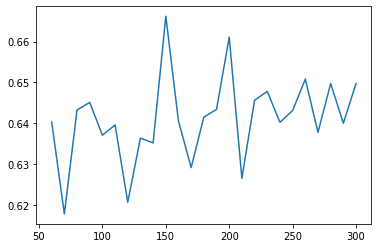

In [222]:
def run_hyper_param_search(vector_func, vector_combo_func):
        metric_key = "macro-F1"
        dim_list = []
        score_list = []
        #base_score = word_disjoint_experiment[metric_key]
        base_score = 0.67
        for dims in range(1,26):
            final_dims = 50+dims*10
            net = TorchShallowNeuralClassifier(hidden_dim=final_dims, max_iter=100)
            word_disjoint_experiment = nli.wordentail_experiment(
                train_data=wordentail_data['word_disjoint']['train'],
                assess_data=wordentail_data['word_disjoint']['dev'], 
                model=net, 
                vector_func=vector_func,
                vector_combo_func=vector_combo_func)
            score = word_disjoint_experiment[metric_key]
            if score > base_score:
                ("following pair beat it")
            print(final_dims, score)
            dim_list.append(final_dims)
            score_list.append(score)
        plot(dim_list, score_list)
        return dim_list, score_list
    

run_hyper_param_search(glove_vec_mine, vec_concatenate)
"""
net = TorchDeepNeuralClassifier(hidden_dim=300, max_iter=100)
word_disjoint_experiment = nli.wordentail_experiment(
    train_data=wordentail_data['word_disjoint']['train'],
    assess_data=wordentail_data['word_disjoint']['dev'], 
    model=net, 
    vector_func=glove_vec_mine,
    vector_combo_func=vec_concatenate)

"""

## Bake-off [1 point]

The goal of the bake-off is to achieve the highest macro-average F1 score on __word_disjoint__, on a test set that we will make available at the start of the bake-off. The announcement will go out on the discussion forum. To enter, you'll be asked to run `nli.bake_off_evaluation` on the output of your chosen `nli.wordentail_experiment` run. 

The cells below this one constitute your bake-off entry.

The rules described in the [Your original system](#Your-original-system-[3-points]) homework question are also in effect for the bake-off.

Systems that enter will receive the additional homework point, and systems that achieve the top score will receive an additional 0.5 points. We will test the top-performing systems ourselves, and only systems for which we can reproduce the reported results will win the extra 0.5 points.

Late entries will be accepted, but they cannot earn the extra 0.5 points. Similarly, you cannot win the bake-off unless your homework is submitted on time.

The announcement will include the details on where to submit your entry.

In [ ]:
# Enter your bake-off assessment code into this cell. 
# Please do not remove this comment.
##### YOUR CODE HERE




In [ ]:
# On an otherwise blank line in this cell, please enter
# your macro-avg f1 value as reported by the code above. 
# Please enter only a number between 0 and 1 inclusive.
# Please do not remove this comment.

##### YOUR CODE HERE


